# 0.01451-model w/ VAR

In [32]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import itertools

In [33]:
# ----- Загрузка и подготовка данных -----

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full_data = pd.concat([train, test], ignore_index=True)
full_data['dt'] = pd.to_datetime(full_data['dt'])
full_data = full_data.sort_values('dt').reset_index(drop=True)

ts = full_data.set_index('dt')[['high', 'low', 'close']].copy()

In [34]:
# ----- Фичи под VAR -----

ts['range'] = ts['high'] - ts['low']
ts['ma3']  = ts['close'].rolling(3).mean()
ts['ma5']  = ts['close'].rolling(5).mean()
ts['vol3'] = ts['close'].pct_change().rolling(3).std()
ts = ts.dropna()

log_cols = ['high', 'low', 'close', 'ma3', 'ma5']
l1p_cols = ['range', 'vol3']

ts_log = np.log(ts[log_cols])
ts_l1p = np.log1p(ts[l1p_cols].clip(lower=0))
X = pd.concat([ts_log, ts_l1p], axis=1)
X_diff = X.diff().dropna()

In [35]:
# ----- Обучение VAR -----

print("Обучение VAR...")
maxlags = 2
var = VAR(X_diff)
fit = var.fit(maxlags=maxlags, ic='aic')
p = fit.k_ar
print(f"Оптимальное число лагов по AIC (<= {maxlags}): {p}")

Обучение VAR...
Оптимальное число лагов по AIC (<= 2): 2


In [36]:
# ----- Прогноз VAR -----

H = 13
last_block = X_diff.values[-p:]
fc_diff = fit.forecast(y=last_block, steps=H)
fc_diff = pd.DataFrame(fc_diff, columns=X_diff.columns, index=pd.date_range(X.index[-1] + pd.Timedelta(days=1), periods=H))

last_levels = X.iloc[-1]
fc_levels = fc_diff.cumsum().add(last_levels, axis='columns')

fc = pd.DataFrame(index=fc_levels.index)
for c in log_cols:
    fc[c] = np.exp(fc_levels[c])
for c in l1p_cols:
    fc[c] = np.clip(np.expm1(fc_levels[c]), a_min=0, a_max=None)

var_close = fc['close'].copy()

In [37]:
# ----- Адаптивная коррекция тренда -----

recent_trend = ts['close'].pct_change().rolling(3).mean().iloc[-1]
adj_default = np.clip(1.0 + 1.15 * (recent_trend if pd.notnull(recent_trend) else 0.0), 0.97, 1.03)
var_close_adj = var_close * adj_default

In [38]:
# ----- Holt-Winters -----

es = ExponentialSmoothing(ts['close'], trend='add', seasonal=None, initialization_method='estimated')
es_fit = es.fit(optimized=True, use_brute=True)
es_fc = es_fit.forecast(H)
es_fc.index = var_close.index

In [39]:
# ----- Валидация + локальная коррекция VAR -----

VAL = 13
X_train = X.iloc[:-VAL]
X_test_dates = X.index[-VAL:]
X_diff_train = X_train.diff().dropna()

var_val = VAR(X_diff_train).fit(maxlags=p, ic=None)
p_val = var_val.k_ar

fc_val_diff = var_val.forecast(X_diff_train.values[-p_val:], steps=VAL)
fc_val_diff = pd.DataFrame(fc_val_diff, columns=X_diff_train.columns,
                           index=pd.date_range(X_train.index[-1] + pd.Timedelta(days=1), periods=VAL))

last_levels_val = X_train.iloc[-1]
fc_val_levels = fc_val_diff.cumsum().add(last_levels_val, axis='columns')

fc_val = pd.DataFrame(index=X_test_dates)
for c in log_cols:
    fc_val[c] = np.exp(fc_val_levels[c].values)
for c in l1p_cols:
    fc_val[c] = np.clip(np.expm1(fc_val_levels[c].values), a_min=0, a_max=None)


var_residuals = ts.loc[X_test_dates, 'close'] - fc_val['close']
local_shift = var_residuals.mean()
var_val_close_adj = fc_val['close'] + local_shift

es_tr = ExponentialSmoothing(ts.loc[X_train.index, 'close'], trend='add', seasonal=None, initialization_method='estimated')
es_tr_fit = es_tr.fit(optimized=True, use_brute=True)
es_tr_fc = es_tr_fit.forecast(VAL)
es_tr_fc.index = X_test_dates

y_true = ts.loc[X_test_dates, 'close'].values

# Автоподбор весов
w_var_range = np.linspace(0.5, 0.9, 9)
trend_adj_range = np.linspace(0.95, 1.05, 11)

best_rmse = np.inf
best_w, best_tr = None, None

for w_var_try, tr_try in itertools.product(w_var_range, trend_adj_range):
    w_es_try = 1 - w_var_try
    final_try = (w_var_try * var_val_close_adj.values * tr_try) + (w_es_try * es_tr_fc.values)
    rmse_try = np.sqrt(mean_squared_error(y_true, final_try))
    if rmse_try < best_rmse:
        best_rmse = rmse_try
        best_w, best_tr = w_var_try, tr_try

print(f"Оптимальные параметры: w_var={best_w:.2f}, тренд_коэф={best_tr:.3f}, RMSE={best_rmse:.6f}")

final_val = (best_w * var_val_close_adj.values * best_tr) + ((1-best_w) * es_tr_fc.values)
final_close_opt = (best_w * (var_close_adj + local_shift).values * best_tr) + ((1-best_w) * es_fc.values)

Оптимальные параметры: w_var=0.55, тренд_коэф=1.050, RMSE=0.084974


In [40]:
# ----- Финальный сабмит -----

submission = pd.DataFrame({
    'ID': range(1, H + 1),
    'close': final_close_opt
})
submission.to_csv('submission.csv', index=False)
print("submission.csv сохранён с оптимизированными параметрами.")

submission.csv сохранён с оптимизированными параметрами.


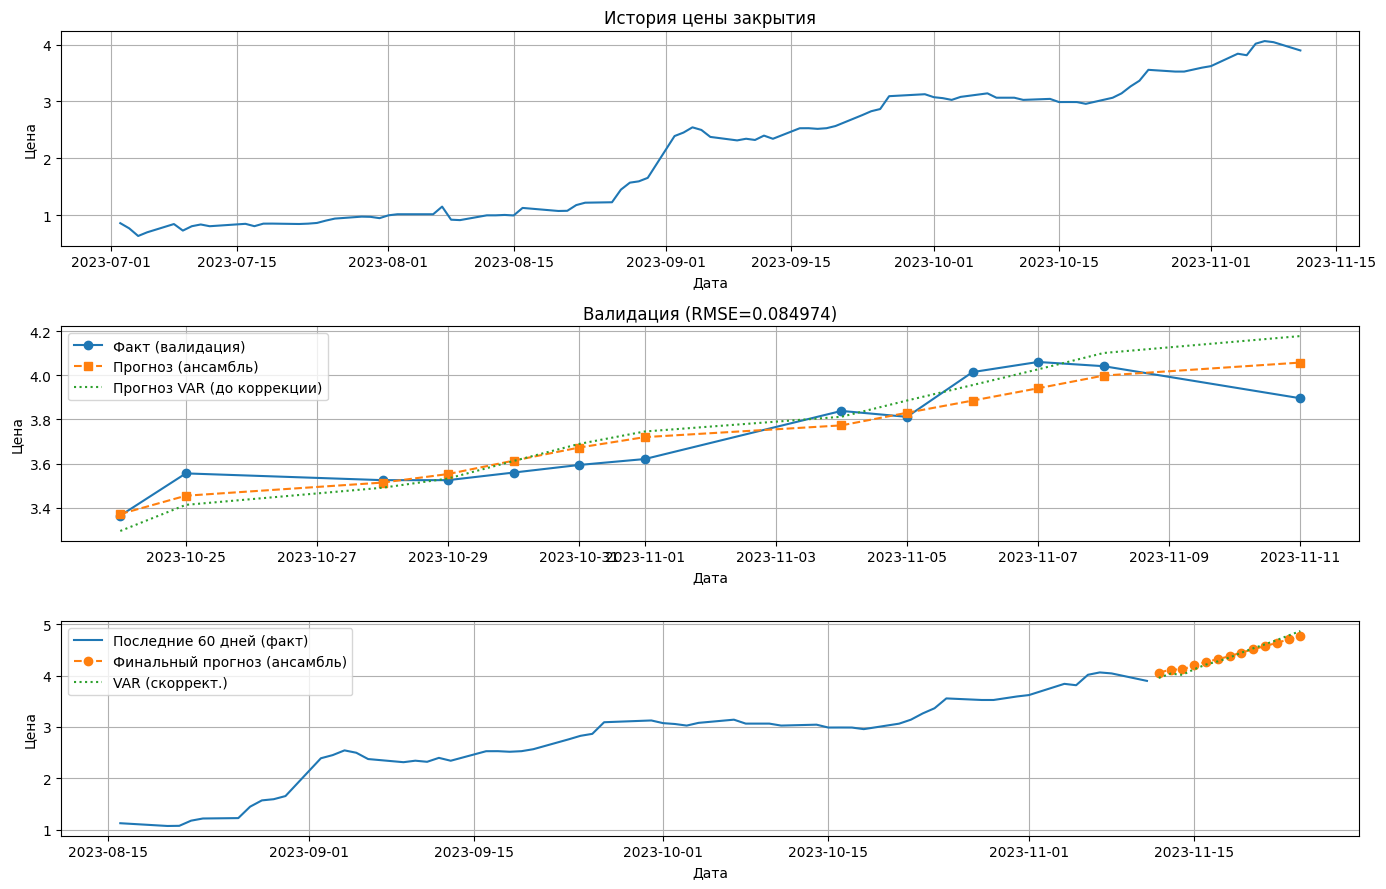


Финальный прогноз на 13 дней (первые строки):
   ID     close
0   1  4.053529
1   2  4.116113
2   3  4.118483
3   4  4.197084
4   5  4.265757


In [41]:
# ----- Визуализация -----

plt.figure(figsize=(14, 9))

plt.subplot(3, 1, 1)
plt.plot(full_data['dt'], full_data['close'], label='Исторические close')
plt.title('История цены закрытия')
plt.grid(True)
plt.xlabel('Дата'); plt.ylabel('Цена')

plt.subplot(3, 1, 2)
val_dates = ts.loc[X_test_dates].index
plt.plot(val_dates, y_true, 'o-', label='Факт (валидация)')
plt.plot(val_dates, final_val, 's--', label='Прогноз (ансамбль)')
plt.plot(val_dates, fc_val['close'], ':', label='Прогноз VAR (до коррекции)')
plt.title(f'Валидация (RMSE={best_rmse:.6f})')
plt.grid(True); plt.legend()
plt.xlabel('Дата'); plt.ylabel('Цена')

plt.subplot(3, 1, 3)
future_dates = pd.date_range(ts.index[-1] + pd.Timedelta(days=1), periods=H)
plt.plot(ts.index[-60:], ts['close'][-60:], label='Последние 60 дней (факт)')
plt.plot(future_dates, final_close_opt, 'o--', label='Финальный прогноз (ансамбль)')
plt.plot(future_dates, var_close_adj + local_shift, ':', label='VAR (скоррект.)')
plt.grid(True); plt.legend()
plt.xlabel('Дата'); plt.ylabel('Цена')

plt.tight_layout()
plt.savefig('validation.png', dpi=300)
plt.show()

print("\nФинальный прогноз на 13 дней (первые строки):")
print(submission.head())
